In [1]:
]st

    Status `/mnt/E4E0A9C0E0A998F6/github/ReinforcementLearningAnIntroduction.jl/notebooks/Project.toml`
  [31c24e10] Distributions v0.22.4
  [91a5bcdd] Plots v0.28.4
  [02c1da58] RLIntro v0.2.0 [`..`]
  [e575027e] ReinforcementLearningBase v0.5.0 [`~/workspace/github/ReinforcementLearningBase.jl`]
  [de1b191a] ReinforcementLearningCore v0.1.0 [`~/workspace/github/ReinforcementLearningCore`]
  [2913bbd2] StatsBase v0.32.0
  [f3b207a7] StatsPlots v0.12.0
  [2f01184e] SparseArrays 


In [2]:
using StatsBase
using ReinforcementLearningCore, RLIntro, RLIntro.MultiArmBandits
using Plots, StatsPlots

default(size=(800, 600))

┌ Info: Precompiling ReinforcementLearningCore [de1b191a-4ae0-4afa-a27b-92d07f46b2d6]
└ @ Base loading.jl:1273
┌ Info: Precompiling RLIntro [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1273
┌ Warning: Package RLIntro does not have Flux in its dependencies:
│ - If you have RLIntro checked out for development and have
│   added Flux as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RLIntro
└ Loading Flux into RLIntro from project dependency, future warnings for RLIntro are suppressed.


In [3]:
env = MultiArmBanditsEnv()

MultiArmBanditsEnv([-0.24996786514940825, 0.10308000562665681, -1.7020402638149013, 1.356632705342288, 0.7139841924273701, 0.014199378337461965, 0.32574639216422097, -0.5971049224870989, 0.02391214352905643, 0.38548970922726017], 0.0, 4, false, 0.0, false, DiscreteSpace{UnitRange{Int64}}(1:1), DiscreteSpace{UnitRange{Int64}}(1:10))

Let's visualize the possible rewards for each action first:

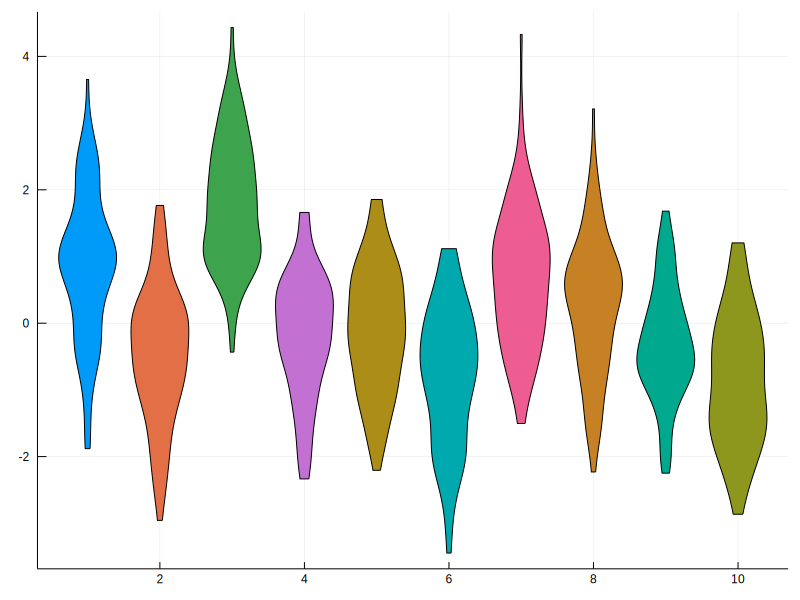

In [45]:
violin([randn(100) .+ x for x in env.truevalues], leg=false)

Here we define a customized hook first to collect the info that our action is the best one or not.

In [6]:
struct CollectBestActions <: AbstractHook
    isbest::Vector{Bool}
    CollectBestActions() = new(Vector{Bool}())
end

(h::CollectBestActions)(::PostActStage, agent, env, obs) = push!(h.isbest, env.isbest)

Now we create a testbed to explore the impact of different ϵ.

In [15]:
function bandit_testbed(;explorer=EpsilonGreedyExplorer(0.1), truereward=0.0, init=0., opt=InvDecay(1.0))
    env = MultiArmBanditsEnv(truereward=truereward)
    agent = Agent(
        policy=QBasedPolicy(
            TDLearner(
                approximator = TabularApproximator(
                    n_state=length(get_observation_space(env)),
                    n_action=length(get_action_space(env)),
                    init=init
                ),
                optimizer = opt
            ),
            explorer
        ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    best_action_stats, reward_stats = CollectBestActions(), RewardsPerEpisode()
    run(agent, env, StopAfterStep(1000),ComposedHook(best_action_stats, reward_stats))
    collect(Iterators.flatten(reward_stats.rewards)),best_action_stats.isbest
end

bandit_testbed (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


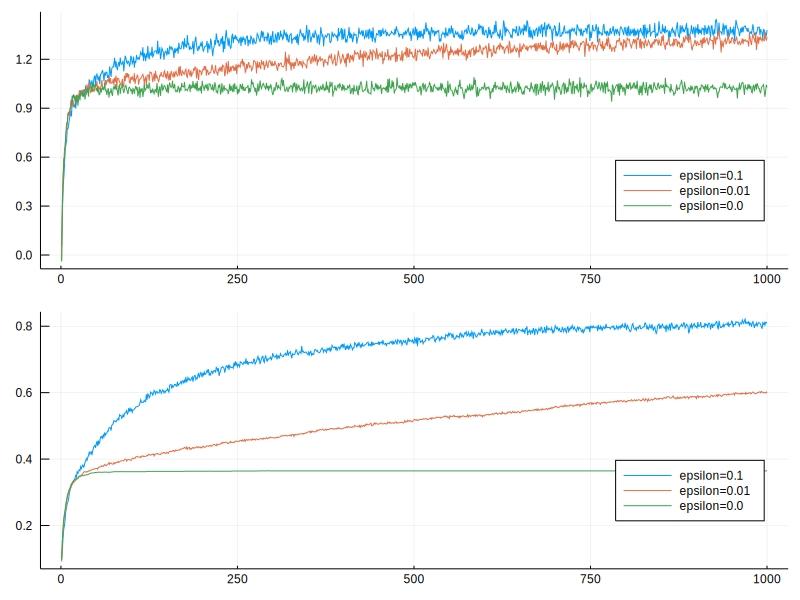

In [49]:
p = plot(layout=(2, 1))
for ϵ in [0.1, 0.01, 0.0]
    stats = [bandit_testbed(;selector=EpsilonGreedyExplorer(ϵ)) for _ in 1:2000]
    plot!(p, mean(x[1] for x in stats), subplot=1, legend=:bottomright, label="epsilon=$ϵ")
    plot!(p, mean(x[2] for x in stats), subplot=2, legend=:bottomright, label="epsilon=$ϵ")
end

p

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


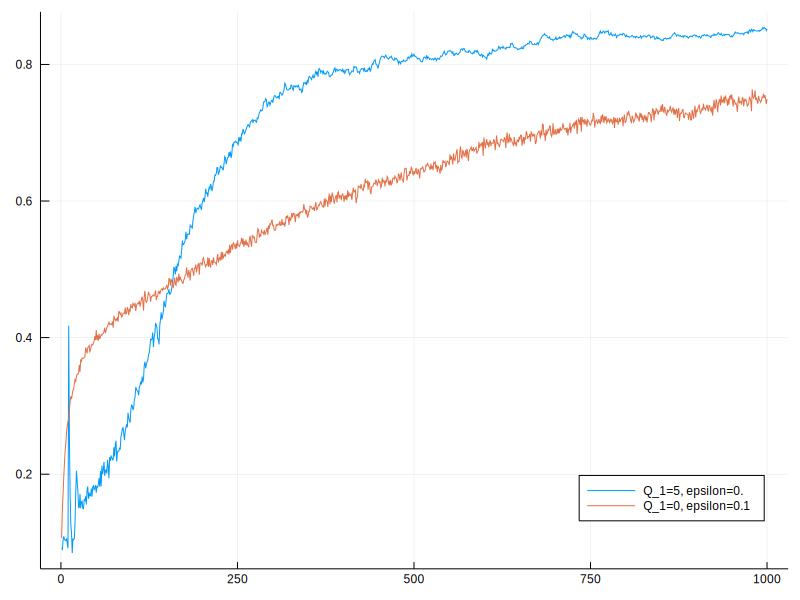

In [50]:
p = plot(legend=:bottomright)
plot!(p, mean(bandit_testbed(;selector=EpsilonGreedyExplorer(0.), init=5., opt=Descent(0.1))[2] for _ in 1:2000), label="Q_1=5, epsilon=0.")
plot!(p, mean(bandit_testbed(;selector=EpsilonGreedyExplorer(0.1), init=0., opt=Descent(0.1))[2] for _ in 1:2000), label="Q_1=0, epsilon=0.1")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


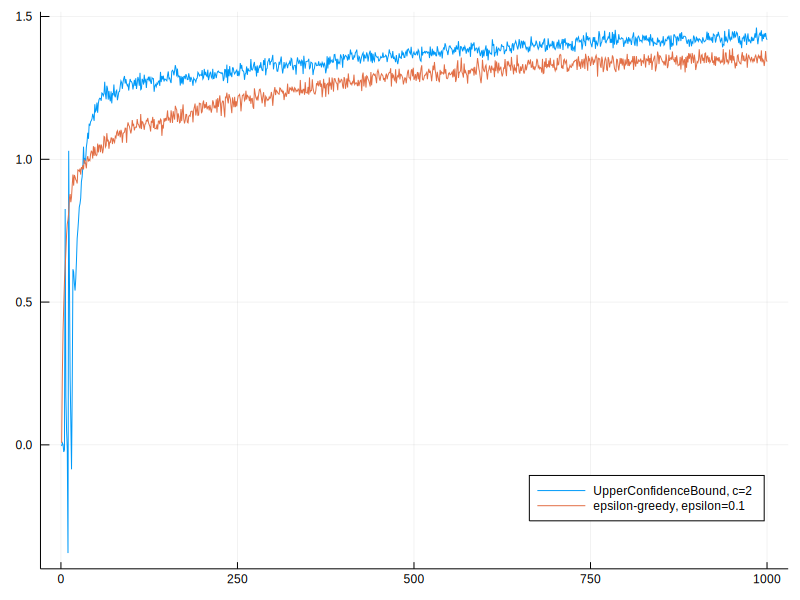

In [52]:
p = plot(legend=:bottomright)
plot!(p, mean(bandit_testbed(;selector=UCBExplorer(10), opt=Descent(0.1))[1] for _ in 1:5000), label="UpperConfidenceBound, c=2")
plot!(p, mean(bandit_testbed(;selector=EpsilonGreedyExplorer(0.1), opt=Descent(0.1))[1] for _ in 1:5000), label="epsilon-greedy, epsilon=0.1")

p

In [16]:
function gb_bandit_testbed(;baseline=0., explorer=WeightedExplorer(is_normalized=true), truereward=0.0, init=0., opt=InvDecay(1.0))
    env = MultiArmBanditsEnv(truereward=truereward)
    agent = Agent(
        policy=QBasedPolicy(
            learner=GradientBanditLearner(
                approximator=TabularApproximator(
                    n_state=length(get_observation_space(env)),
                    n_action=length(get_action_space(env)),
                    init=init
                ),
                optimizer=opt,
                baseline=baseline
            ),
            explorer=explorer
        ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    best_action_stats, reward_stats = CollectBestActions(), RewardsPerEpisode()
    run(agent, env, StopAfterStep(1000), ComposedHook(best_action_stats, reward_stats))
    collect(Iterators.flatten(reward_stats.rewards)),best_action_stats.isbest
end

gb_bandit_testbed (generic function with 1 method)

As you can see, the only difference of `gb_bandit_testbed` compared to `bandit_testbed` is that it uses `GradientBanditLearner` instread of `TDLearner`.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


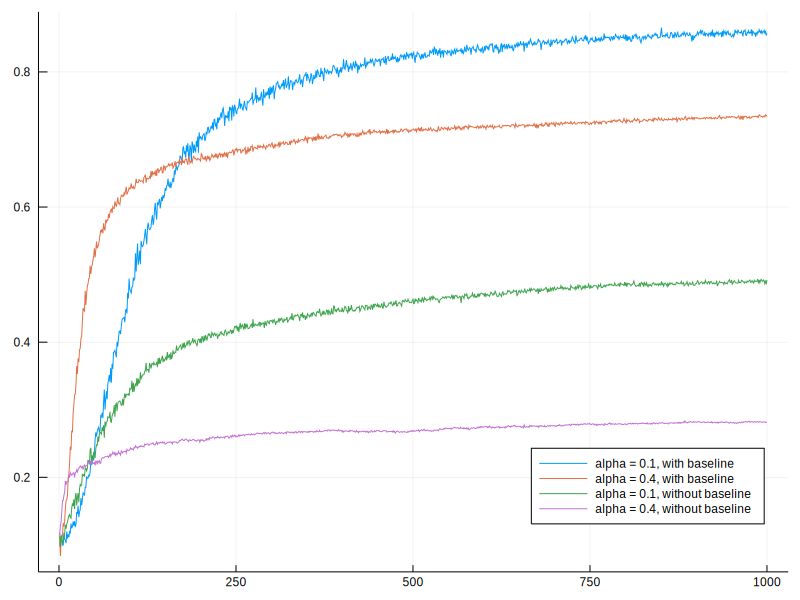

In [9]:
truereward = 4.0

p = plot(legend=:bottomright)

plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.1), baseline=SampleAvg(), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.1, with baseline")
plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.4), baseline=SampleAvg(), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.4, with baseline")
plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.1), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.1, without baseline")
plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.4), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.4, without baseline")

p

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


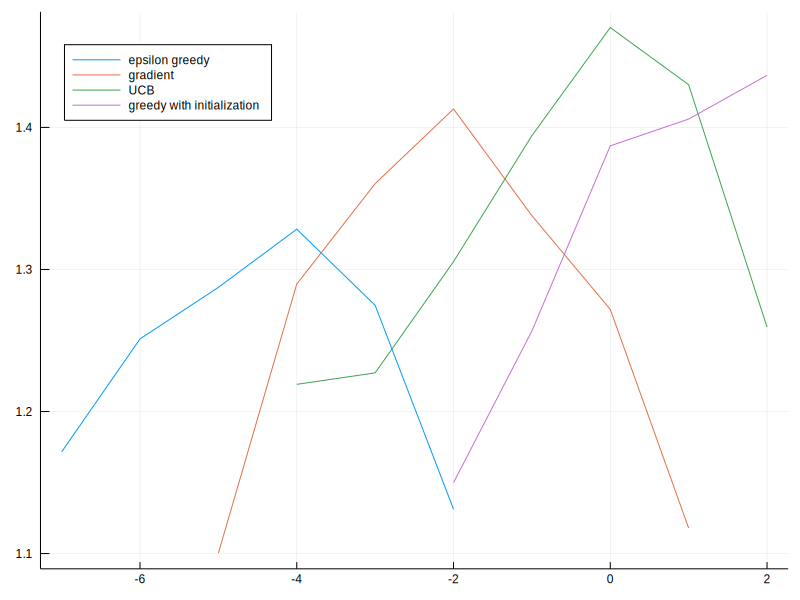

In [17]:
p = plot(legend=:topleft)

plot!(p, -7:-2, [mean(mean(bandit_testbed(;explorer=EpsilonGreedyExplorer(2.0^i))[1] for _ in 1:2000)) for i in -7:-2], label="epsilon greedy")
plot!(p, -5:1, [mean(mean(gb_bandit_testbed(;explorer=WeightedExplorer(is_normalized=true), opt=Descent(2.0^i))[1] for _ in 1:2000)) for i in -5:1], label="gradient")
plot!(p, -4:2, [mean(mean(bandit_testbed(;explorer=UCBExplorer(10; c=2.0^i))[1] for _ in 1:2000)) for i in -4:2], label="UCB")
plot!(p, -2:2, [mean(mean(bandit_testbed(;explorer=EpsilonGreedyExplorer(0.), init=(2.0^i))[1] for _ in 1:2000)) for i in -2:2], label="greedy with initialization")

p